В таблице regs.csv находится количество регистраций пользователей в еЛаме по месяцам по июль 2022
Требуется написать Python-скрипт, который прогнозирует количество регистраций в августе 2022.

Ответ предоставить в виде кода скрипта в Jupiter Notebook или Google Colab и таблицы, содержащей исходный временной ряд и прогнозное значение на 2022-08.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.dummy import DummyClassifier
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima
!pip install lightgbm
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [2]:
regs = pd.read_csv('regs.csv', parse_dates=['period'], index_col='period')

In [3]:
regs


,users
period,
2020-06-01,8623
2020-07-01,7904
2020-08-01,8237
2020-09-01,9267
2020-10-01,8868
2020-11-01,8058
2020-12-01,7422
2021-01-01,8233
2021-02-01,8571


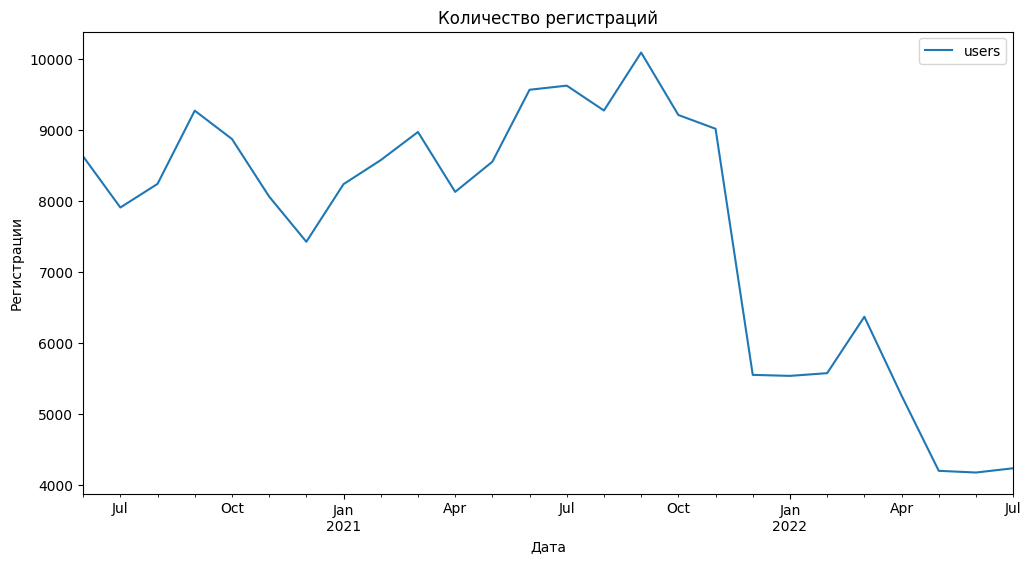

In [4]:
# Визуализация временного ряда
regs.plot(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Регистрации')
plt.title('Количество регистраций')
plt.show()

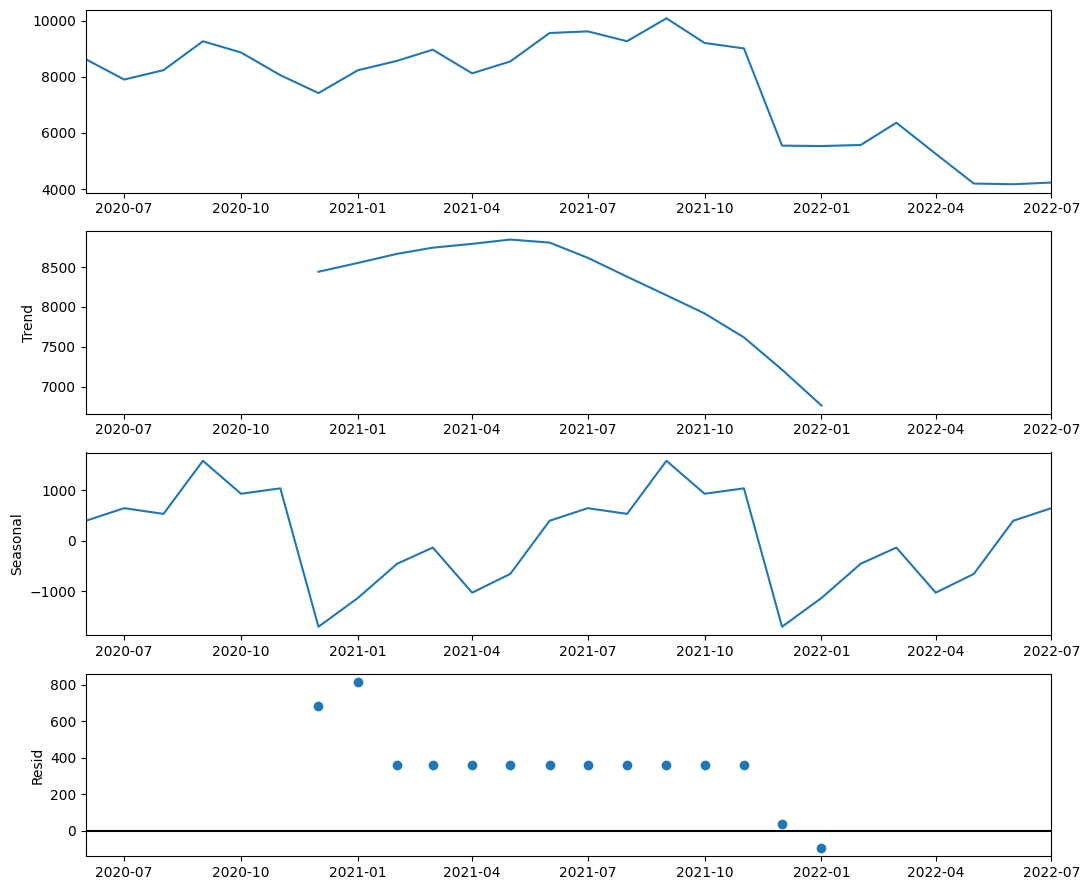

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(regs)
decompose.plot()

plt.show()

Проверим временной ряд на стационарность. Используем пороговое значение, равное 0,05 (5%)

In [6]:
adf_test = adfuller(regs['users'])

# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.8617883036448093


P-value - явно выше 0.05, можем сделать вывод, что ряд нестационарен.



## Добавим новые признаки в исходную таблицу

Создадим столбец с количеством дней в месяце

In [7]:
regs['days_in_month'] = regs.index.days_in_month


Создадим столбец выходных и праздников

In [8]:
class RussianHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('Новый Год', month=1, day=1),
        Holiday('Рождество', month=1, day=7),
        Holiday('День защитника отечества', month=2, day=23),
        Holiday('Международный женский день', month=3, day=8),
        Holiday('День труда', month=5, day=1),
        Holiday('День Победы', month=5, day=9),
        Holiday('День России', month=6, day=12),
        Holiday('День народного единства', month=11, day=4),
    ]

# Создаем календарь с праздниками России
rus_cal = RussianHolidays()

# Создаем массив с датами, для которых будем проверять, являются ли они выходными или праздниками
dates = pd.date_range(start='2020-06-01', end='2022-07-02', freq='D')

# Создаем серию с информацией о том, являются ли даты выходными или праздниками
is_holiday_series = dates.to_series().isin(rus_cal.holidays(start=dates.min(), end=dates.max())) | dates.to_series().dt.dayofweek.isin([5, 6])

# Создаем DataFrame с датами и флагами выходных/праздничных дней
holidays_df = pd.DataFrame({'date': dates, 'is_holiday': is_holiday_series})



regs = pd.merge(regs, holidays_df, left_on='period', right_on='date', how='left')

regs.drop(columns='date', inplace=True)

print(regs)

    users  days_in_month  is_holiday
0    8623             30       False
1    7904             31       False
2    8237             31        True
3    9267             30       False
4    8868             31       False
5    8058             30        True
6    7422             31       False
7    8233             31        True
8    8571             28       False
9    8967             31       False
10   8124             30       False
11   8548             31        True
12   9561             30       False
13   9619             31       False
14   9269             31        True
15  10085             30       False
16   9206             31       False
17   9012             30       False
18   5549             31       False
19   5535             31        True
20   5573             28       False
21   6367             31       False
22   5258             30       False
23   4199             31        True
24   4175             30       False
25   4235             31       False


## Разделим данные на test и train

In [9]:
# Разделим данные на обучающую и тестовую выборки
train = regs[0:20]
test = regs.loc[20:]

## Создадим наивный прогноз

In [10]:
# Получение последнего известного значения из обучающей выборки
last_value = train['users'].iloc[-1]

# Создание наивного прогноза
naive_forecast = pd.Series([last_value] * len(test), index=test.index)

# Оценка производительности наивного прогноза
mse = mean_squared_error(test['users'], naive_forecast)
mae = mean_absolute_error(test['users'], naive_forecast)

print('Naive Forecast:')
print(naive_forecast)
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)

Naive Forecast:
20    5535
21    5535
22    5535
23    5535
24    5535
25    5535
dtype: int64
Mean Squared Error (MSE): 1015815.5
Mean Absolute Error (MAE): 857.1666666666666


## Linear Regression

In [11]:
features_train = train.drop('users', axis=1)
target_train = train['users']

features_test = test.drop('users', axis=1)
target_test = test['users']


In [12]:
%%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split

model = LinearRegression()
time_split = TimeSeriesSplit(n_splits=3)
#определяю RMSE модели с помощью кросс-валидации
regression_cv_score = (cross_val_score(model, features_train, target_train, cv=time_split,
                                                scoring='neg_mean_absolute_error', error_score='raise').mean()*-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 1082.39643533818
CPU times: user 27.3 ms, sys: 858 µs, total: 28.1 ms
Wall time: 60.1 ms


## Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
parameters = {"max_depth": [1, 10], "n_estimators": [100, 150, 10]}

RF_grid = GridSearchCV(model, parameters, cv=time_split, verbose=10, n_jobs=-1)
RF_grid.fit(features_train, target_train)

print("Лучшие параметры модели:", RF_grid.best_params_)

# Предсказание на тестовой выборке
forecast = RF_grid.predict(features_test)

# Рассчитаем MAE
mae = mean_absolute_error(target_test, forecast)

print("Mean Absolute Error (MAE):", mae)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Лучшие параметры модели: {'max_depth': 10, 'n_estimators': 100}
Mean Absolute Error (MAE): 3600.667104802605


## LightGBM

In [15]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split

param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}
time_split = TimeSeriesSplit(n_splits=3)

# Создадим массивы признаков и целевых значений
train['period'] = train.index  # Добавим столбец period из индекса
test['period'] = test.index    # Добавим столбец period из индекса

features_train = train[['period', 'days_in_month', 'is_holiday']]
target_train = train['users']
features_test = test[['period', 'days_in_month', 'is_holiday']]
target_test = test['users']

model = lgb.LGBMRegressor(random_state=12345)

testing_model = GridSearchCV(estimator=model,
                             param_grid=param_grid,
                             scoring='neg_mean_absolute_error',
                             cv=time_split,
                             verbose=10, n_jobs=-1)

testing_model.fit(features_train, target_train)
display('Лучшие параметры модели:', testing_model.best_params_)
display('Лучшая метрика модели:', testing_model.best_score_ * -1)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


<ipython-input-15-ed545a50df58>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['period'] = train.index  # Добавим столбец period из индекса
<ipython-input-15-ed545a50df58>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['period'] = test.index    # Добавим столбец period из индекса


'Лучшие параметры модели:'

{'n_estimators': 100, 'num_leaves': 20}

'Лучшая метрика модели:'

976.7555555555554

## Prophet

In [16]:
#%%time

#m = Prophet(changepoint_prior_scale=0.1, holidays=holidays, holidays_prior_scale=18)
#m.fit(train_df);

#future = m.make_future_dataframe(periods=predictions)

#forecast_test = m.predict(future)

## ARIMA

In [17]:
params = {
    "seasonal": False,
    "start_p": 0,
    "start_q": 0,
    "max_p": 5,
    "max_q": 5,
    "m": 12,
}

In [18]:
modeling = auto_arima(
    train,
    seasonal = params["seasonal"],
    start_p=params["start_p"],
    start_q=params["start_q"],
    max_p=params["max_p"],
    max_q=params["max_q"],
    stepwise=True,
)

modeling.fit(train)

ValueError: ignored

In [ ]:
# Определение модели ARIMA с полученными параметрами
model = ARIMA(train, order=(0, 0, 2))
model_fit = model.fit()

# Прогнозирование на тестовом наборе данных
predictions = model_fit.forecast(steps=len(test))

# Вывод прогнозных значений
print(predictions)

In [ ]:
forecast = model_fit.predict(n_periods=len(test))

plt.plot(train['users'], label='Train')
plt.plot(test['users'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()

plt.show()

In [ ]:
# Расчет MSE и MAE
true = regs['users']  # Фактические значения
pred = forecast  # Прогнозные значения
mse = np.mean((true - pred)**2)
mae = np.mean(np.abs(true - pred))

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)